In [1]:
import os, sys

import numpy as np
import pandas as pd
import tensorflow as tf
import random
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
plt.rc('mathtext', fontset="cm")
import matplotlib.ticker as mtick
import seaborn as sns
import matplotlib

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
  sys.path.append(module_path)

from barennet.utils import Create_Similarity_Model

sns.set_style('whitegrid')
sns.set_context("talk")

2023-01-10 15:57:18.896011: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-10 15:57:18.896028: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Now we will create our model

In [2]:
n_nonsimilar = 1
n_similar = 1

### We will look for similarity in the last n_similar parameters of the inputs.

## Load the MVP data for high enough Re

In [3]:
dfSB2M300k_M=pd.read_csv("../../Data/McKeon Data/turb2/Re2300000.txt",  sep="\t", header=None, names = ["datapoint", "y/R", "y+", "U+", "(U+-Ucl+)"])
dfSB3M_M=pd.read_csv("../../Data/McKeon Data/turb2/Re3000000.txt", sep="\t", header=None, names = ["datapoint", "y/R", "y+", "U+", "(U+-Ucl+)"])
dfSB4M_M=pd.read_csv("../../Data/McKeon Data/turb2/Re4000000.txt", sep="\t", header=None, names = ["datapoint", "y/R", "y+", "U+", "(U+-Ucl+)"])
dfSB6M_M=pd.read_csv("../../Data/McKeon Data/turb2/Re6000000.txt", sep="\t", header=None, names = ["datapoint", "y/R", "y+", "U+", "(U+-Ucl+)"])
dfSB7M_M=pd.read_csv("../../Data/McKeon Data/turb2/Re7000000.txt", sep="\t", header=None, names = ["datapoint", "y/R", "y+", "U+", "(U+-Ucl+)"])
dfSB10M_M=pd.read_csv("../../Data/McKeon Data/turb2/Re10000000.txt", sep="\t", header=None, names = ["datapoint", "y/R", "y+", "U+", "(U+-Ucl+)"])
dfSB13M_M=pd.read_csv("../../Data/McKeon Data/turb2/Re13000000.txt", sep="\t", header=None, names = ["datapoint", "y/R", "y+", "U+", "(U+-Ucl+)"])

dfs = [dfSB2M300k_M, dfSB3M_M, dfSB4M_M, dfSB6M_M, dfSB7M_M, dfSB10M_M, dfSB13M_M]
Re_tau = []
Y_ = []
U_ = []
possible_re_tau = [4.229500e+004, 5.453000e+004, 7.647800e+004, 1.022e+005, 1.279200e+005, 1.657e+005, 2.169800e+005]
dic_x = {}
dic_y = {}

for i in range(len(possible_re_tau)):
    possible_y = dfs[i]["y+"].values
    possible_u = dfs[i]["U+"].values
    for j in range(34, len(possible_y)-1):                                     ### training from y/R > 0.1
        Y_.append(possible_y[j])
        U_.append(possible_u[j])
        Re_tau.append(possible_re_tau[i])

c = list(zip(Y_, Re_tau, U_))
random.shuffle(c)
Y_, Re_tau, U_ = zip(*c)

Y_test = np.log(Y_)
Re_tau_test = np.log(Re_tau)
U_test = np.log(U_)

dic_x['y+'] = Y_test
dic_x['re_tau'] = Re_tau_test
dic_y['u+'] = np.array(U_test)

nonsimilar_keys = ['y+']

xtrain = pd.DataFrame.from_dict(dic_x).values
ytrain = pd.DataFrame.from_dict(dic_y).values

In [21]:
loss = 'mean_squared_error'
optimizer = 'adam'
best_loss = 50.0
n_fits = 5                       # Number of model fits we will try to perform
n_epochs_initial = 1000           # Number of epochs we will train inside the loop
n_epochs_final = 10000            # Number of epochs we will train after convergence is established
successfull_tries = 0

# model = Create_Similarity_Model(n_nonsimilar = n_nonsimilar, n_similar = n_similar)
# model.compile(loss = loss, optimizer = optimizer)
# model.fit(xtrain, ytrain, epochs = n_epochs_initial, verbose = 1)

while successfull_tries < n_fits:
    model = Create_Similarity_Model(n_nonsimilar = n_nonsimilar, n_similar = n_similar)
    model.compile(loss = loss, optimizer = optimizer)
    model.fit(xtrain, ytrain, epochs = n_epochs_initial, verbose = 0)
    current_loss = model.evaluate(xtrain, ytrain, verbose = 0)
    if current_loss < 1.0:
        successfull_tries += 1
        model.fit(xtrain, ytrain, epochs = n_epochs_final, verbose = 0)
        good_loss = model.evaluate(xtrain, ytrain, verbose = 0)
        if good_loss < best_loss:
            best_model = model
            best_loss = good_loss
    

In [22]:
# best_model.fit(xtrain, ytrain, epochs = 10000, verbose = 0)
model.evaluate(xtrain, ytrain, verbose = 0)

8.031260222196579e-05

In [23]:
for i in range(n_nonsimilar):
    similarity_exponents = model.get_layer('similarity_layer').weights[0][0].numpy()
    print('Exponents multiplicating inside the function for ' + nonsimilar_keys[i] + ': ' + str(similarity_exponents))

multiplication_exponents = model.get_layer('multiplication_layer').weights[0][0].numpy()
print('Exponents multiplicating outside the function: ' + str(multiplication_exponents))

Exponents multiplicating inside the function for y+: [-1.0758518]
Exponents multiplicating outside the function: [0.0830913]


In [29]:
scaling_factor_y = - similarity_exponents
scaling_factor_u = multiplication_exponents

y_ = []
y__ = []
u_ = []
u__ = []
Re_tau = possible_re_tau
Re = [2.36e+006, 3.11e+006, 4.46e+006, 6.11e+006, 7.81e+006, 1.03e+007, 1.37e+007]

for i in range(len(dfs)):
    yplus = dfs[i]['y+']
    uplus = dfs[i]['U+']
    y_.append(yplus)
    u_.append(uplus)
    y__.append(yplus / (Re_tau[i] ** scaling_factor_y))
    u__.append(uplus / (Re_tau[i] ** scaling_factor_u))

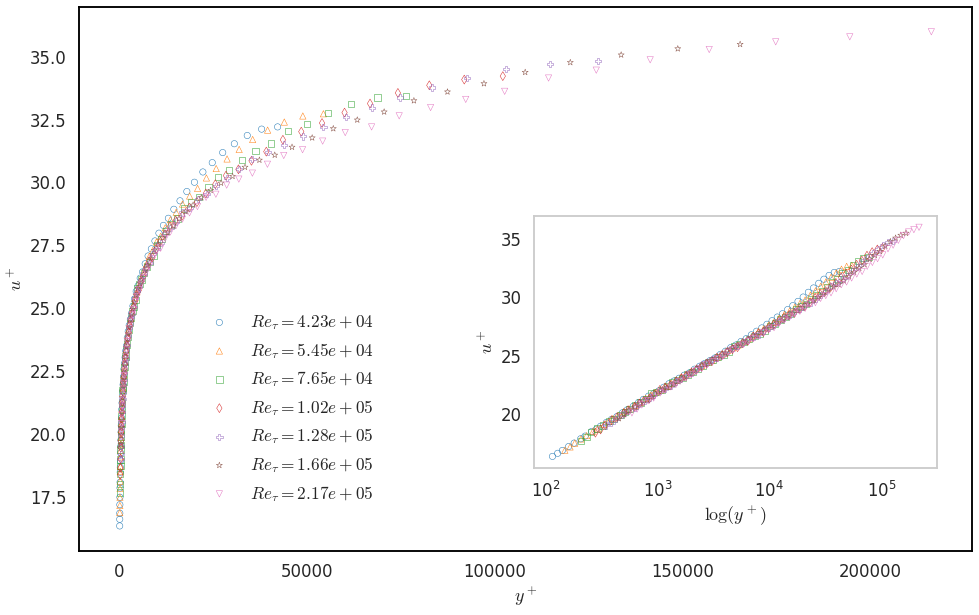

In [35]:
fig, ax1 = plt.subplots(figsize=(16, 10))

left, bottom, width, height = [0.52, 0.24, 0.35, 0.35] 
ax2 = fig.add_axes([left, bottom, width, height])

colors = matplotlib.cm.tab10(np.linspace(0, 1, 10))
markers=['o','^','s','d','P','*','v','X','<']
line_width = 0.5

j=0
for i in range(len(dfs)):
    ax1.scatter(y_[i][:-1] , u_[i][:-1] , s=40 , linewidth = line_width , facecolors='none', color = colors[i], marker = markers[j%len(markers)], label = r'$Re_\tau= $'+r'${:.2e}$'.format(possible_re_tau[i]))
    j+=1

j=0
for i in range(len(dfs)):
    ax2.scatter(y_[i][:-1] , u_[i][:-1] , s=40 , linewidth = line_width, facecolors = 'none', color = colors[i] , marker = markers[j%len(markers)], label = 'Mck, Re= '+'{:.2e}'.format(possible_re_tau[i]))
    j+=1

font = font_manager.FontProperties(family='DejaVu Sans',
                                   weight='roman',
                                   style='normal', size = 'xx-large', stretch = 'ultra-condensed')

ax1.legend(bbox_to_anchor=(0.13, 0.45), loc = 'upper left', edgecolor = 'white', framealpha = 0, prop = font, borderaxespad=0.)
ax1.set_xlabel(r"$y^+$")
ax1.set_ylabel(r'$u^+$')
#ax1.set_ylim([2,15])
ax1.grid(False)
ax1.spines['bottom'].set_color('black')
ax1.spines['top'].set_color('black')
ax1.spines['left'].set_color('black')
ax1.spines['right'].set_color('black')
ax2.set_xlabel(r"$\log(y^+)$")
ax2.set_ylabel(r'$u^+$')
ax2.set_xscale('log')
#ax2.set_xlim([0.01,1])
ax2.grid(False)
plt.savefig('Figures/Example Data for Superpipe MVP.pdf', format='pdf', dpi=1200)
plt.show()

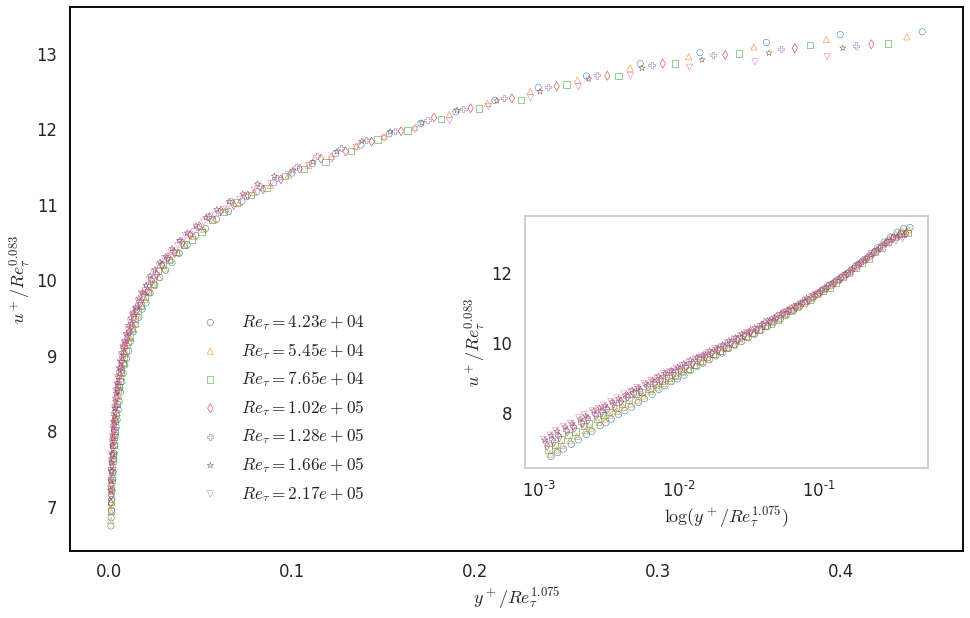

In [36]:
fig, ax1 = plt.subplots(figsize=(16, 10))

left, bottom, width, height = [0.52, 0.24, 0.35, 0.35] 
ax2 = fig.add_axes([left, bottom, width, height])

colors = matplotlib.cm.tab10(np.linspace(0, 1, 10))
markers=['o','^','s','d','P','*','v','X','<']
line_width = 0.5

j=0
for i in range(len(dfs)):
    ax1.scatter(y__[i][:-1] , u__[i][:-1] , s=40 , linewidth = line_width , facecolors='none', color = colors[i], marker = markers[j%len(markers)], label = r'$Re_\tau= $'+r'${:.2e}$'.format(possible_re_tau[i]))
    j+=1

j=0
for i in range(len(dfs)):
    ax2.scatter(y__[i][:-1] , u__[i][:-1] , s=40 , linewidth = line_width, facecolors = 'none', color = colors[i] , marker = markers[j%len(markers)], label = 'Mck, Re= '+'{:.2e}'.format(Re[i]))
    j+=1

font = font_manager.FontProperties(family='DejaVu Sans',
                                   weight='roman',
                                   style='normal', size = 'xx-large', stretch = 'ultra-condensed')

ax1.legend(bbox_to_anchor=(0.13, 0.45), loc = 'upper left', edgecolor = 'white', framealpha = 0, prop = font, borderaxespad=0.)
ax1.set_xlabel(r"$y^+/Re_\tau^{1.075}$")
ax1.set_ylabel(r'$u^+/Re_\tau^{0.083}$')
#ax1.set_ylim([2,15])
ax1.grid(False)
ax1.spines['bottom'].set_color('black')
ax1.spines['top'].set_color('black')
ax1.spines['left'].set_color('black')
ax1.spines['right'].set_color('black')
ax2.set_xlabel(r"$\log(y^+/Re_\tau^{1.075})$")
ax2.set_ylabel(r'$u^+/Re_\tau^{0.083}$')
ax2.set_xscale('log')
#ax2.set_xlim([0.01,1])
ax2.grid(False)
plt.savefig('Figures/Collapsed for Superpipe MVP.pdf', format='pdf', dpi=1200)
plt.show()

## Train without the biggest Re

In [4]:
Re_tau = []
Y_ = []
U_ = []
possible_re_tau = [4.229500e+004, 5.453000e+004, 7.647800e+004, 1.022e+005, 1.279200e+005, 1.657e+005, 2.169800e+005]
dic_x = {}
dic_y = {}

for i in range(len(possible_re_tau) - 1):
    possible_y = dfs[i]["y+"].values
    possible_u = dfs[i]["U+"].values
    for j in range(34, len(possible_y)-1):                                     ### training from y/R > 0.1
        Y_.append(possible_y[j])
        U_.append(possible_u[j])
        Re_tau.append(possible_re_tau[i])

c = list(zip(Y_, Re_tau, U_))
random.shuffle(c)
Y_, Re_tau, U_ = zip(*c)

Y_ = np.log(Y_)
Re_tau = np.log(Re_tau)

dic_x['y+'] = Y_
dic_x['re_tau'] = Re_tau
dic_y['u+'] = np.array(U_)

nonsimilar_keys = ['y+']

xtrain = pd.DataFrame.from_dict(dic_x).values
ytrain = pd.DataFrame.from_dict(dic_y).values

In [5]:
loss = 'mean_squared_error'
optimizer = 'adam'
best_loss = 50.0
n_fits = 20                       # Number of model fits we will try to perform
n_epochs_initial = 1000           # Number of epochs we will train inside the loop
n_epochs_final = 10000            # Number of epochs we will train after convergence is established
successfull_tries = 0
models = []

# model = Create_Similarity_Model(n_nonsimilar = n_nonsimilar, n_similar = n_similar)
# model.compile(loss = loss, optimizer = optimizer)
# model.fit(xtrain, ytrain, epochs = n_epochs_initial, verbose = 2)

while successfull_tries < n_fits:
    model = Create_Similarity_Model(n_nonsimilar = n_nonsimilar, n_similar = n_similar)
    model.compile(loss = loss, optimizer = optimizer)
    model.fit(xtrain, ytrain, epochs = n_epochs_initial, verbose = 0)
    current_loss = model.evaluate(xtrain, ytrain, verbose = 0)
    if current_loss < 1.0:
        successfull_tries += 1
        model.fit(xtrain, ytrain, epochs = n_epochs_final, verbose = 0)
        good_loss = model.evaluate(xtrain, ytrain, verbose = 0)
        models.append(model)
        print("Iteration " + str(successfull_tries) + ": current loss = " + str(good_loss))
        if good_loss < best_loss:
            best_model = model
            best_loss = good_loss
    

2022-07-27 16:22:10.673028: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-27 16:22:10.673222: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-27 16:22:10.673265: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-07-27 16:22:10.673304: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-07-27 16:22:10.673342: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

Iteration 1: current loss = 0.00974668376147747


KeyboardInterrupt: 

In [6]:
j = 0

for model in models:

    for i in range(n_nonsimilar):
        similarity_exponents = model.get_layer('similarity_layer_' + str(i+1)).weights[0][0].numpy()
        print('Exponents multiplicating inside the function for model ' + str(j) + ' in ' + nonsimilar_keys[i] + ': ' + str(similarity_exponents))

    multiplication_exponents = model.get_layer('multiplication_layer').weights[0][0].numpy()
    print('Exponents multiplicating outside the function for model ' + str(j) + ': '  + str(multiplication_exponents))
    j += 1

for i in range(n_nonsimilar):
    similarity_exponents = best_model.get_layer('similarity_layer_' + str(i+1)).weights[0][0].numpy()
    print('Exponents multiplicating inside the function for  best model: ' + nonsimilar_keys[i] + ': ' + str(similarity_exponents))

multiplication_exponents = best_model.get_layer('multiplication_layer').weights[0][0].numpy()
print('Exponents multiplicating outside the function for best model: '  + str(multiplication_exponents))

Exponents multiplicating inside the function for model 0 in y+: [-1.0069703]
Exponents multiplicating outside the function for model 0: [0.07769417]
Exponents multiplicating inside the function for  best model: y+: [-1.0069703]
Exponents multiplicating outside the function for best model: [0.07769417]


In [7]:
filepath = 'Models/Extreme Re prediction model'
best_model.save(filepath= filepath)

INFO:tensorflow:Assets written to: Models/Extreme Re prediction model/assets


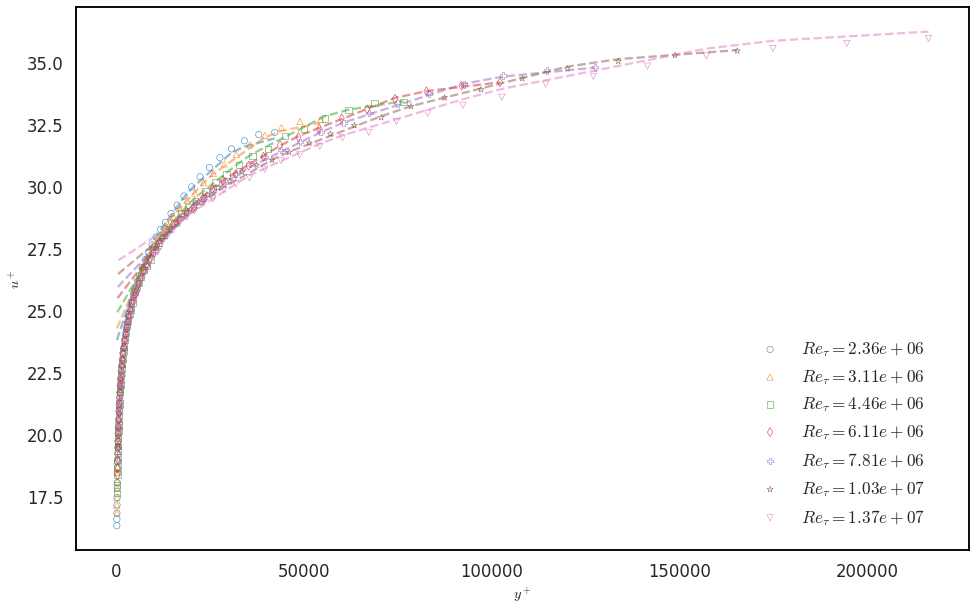

In [10]:
model = tf.keras.models.load_model(filepath = filepath)

fig, ax1 = plt.subplots(figsize=(16, 10))

Re = [2.36e+006, 3.11e+006, 4.46e+006, 6.11e+006, 7.81e+006, 1.03e+007, 1.37e+007]

colors = matplotlib.cm.tab10(np.linspace(0, 1, 10))
markers=['o','^','s','d','P','*','v','X','<']
line_width = 0.5

dic_x = {}
dic_y = {}

j = 0
for i in range(len(dfs)):
    Y_ = []
    Re_tau = []
    U_ = []
    re_tau = possible_re_tau[i]
    possible_y_= dfs[i]['y+']
    for k in range(len(possible_y_)):
        Y_.append(possible_y_[k])
        Re_tau.append(re_tau)
        U_.append(dfs[i]['U+'].iloc[k])
    Y_ = np.log(Y_)
    Re_tau = np.log(Re_tau)
    dic_x['y+'] = Y_
    dic_x['re_tau'] = Re_tau

    xtest = pd.DataFrame.from_dict(dic_x).values
    pred = model.predict(xtest, verbose = 0)
    ax1.plot(np.exp(Y_)[:-1], pred[:-1], color = colors[j], alpha = 0.5, linestyle = 'dashed')
    ax1.scatter(np.exp(Y_)[:-1], U_[:-1], s=40 , linewidth = line_width , facecolors='none', color = colors[j], marker = markers[j%len(markers)], label = r'$Re_\tau= $'+r'${:.2e}$'.format(Re[i]))
    j +=1

font = font_manager.FontProperties(family='DejaVu Sans',
                                   weight='roman',
                                   style='normal', size = 'xx-large', stretch = 'ultra-condensed')

ax1.legend(bbox_to_anchor=(0.75, 0.4), loc = 'upper left', edgecolor = 'white', framealpha = 0, prop = font, borderaxespad=0.)
ax1.set_xlabel(r"$y^+$", size = 'x-large')
ax1.set_ylabel(r'$u^+$', size = 'x-large')
#ax1.set_ylim([2,15])
ax1.grid(False)
ax1.spines['bottom'].set_color('black')
ax1.spines['top'].set_color('black')
ax1.spines['left'].set_color('black')
ax1.spines['right'].set_color('black')
plt.savefig('Figures/BarenNet prediction for Superpipe MVP.pdf', format='pdf', dpi=1200)
plt.show()

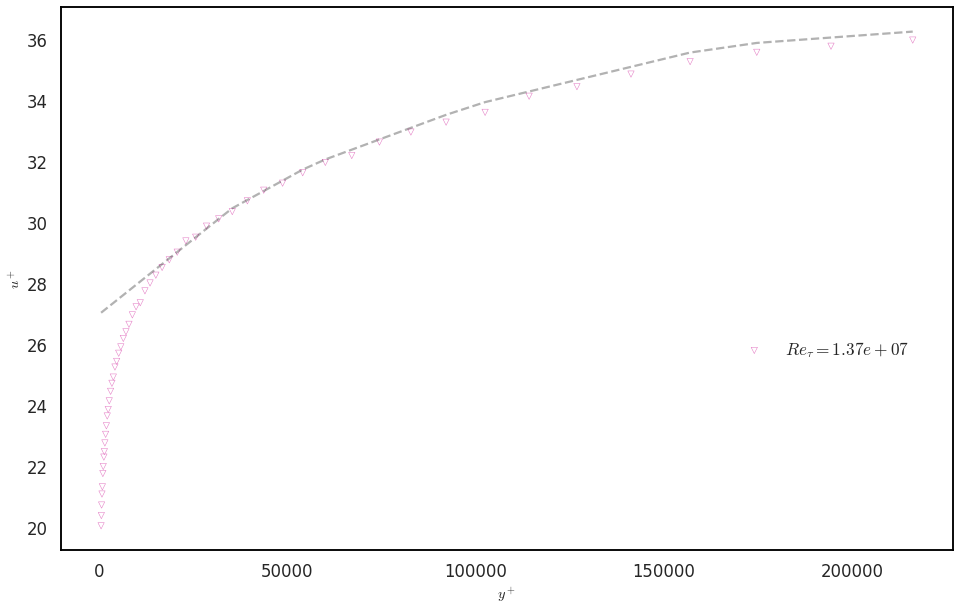

In [14]:
fig, ax1 = plt.subplots(figsize=(16, 10))

Re = [2.36e+006, 3.11e+006, 4.46e+006, 6.11e+006, 7.81e+006, 1.03e+007, 1.37e+007]

colors = matplotlib.cm.tab10(np.linspace(0, 1, 10))
markers=['o','^','s','d','P','*','v','X','<']
line_width = 0.5

dic_x = {}
dic_y = {}

j = 6
for i in range(len(dfs) - 1, len(dfs)):
    Y_ = []
    Re_tau = []
    U_ = []
    re_tau = possible_re_tau[i]
    possible_y_= dfs[i]['y+']
    for k in range(len(possible_y_)):
        Y_.append(possible_y_[k])
        Re_tau.append(re_tau)
        U_.append(dfs[i]['U+'].iloc[k])
    Y_ = np.log(Y_)
    Re_tau = np.log(Re_tau)
    dic_x['y+'] = Y_
    dic_x['re_tau'] = Re_tau

    xtest = pd.DataFrame.from_dict(dic_x).values
    pred = model.predict(xtest, verbose = 0)
    ax1.plot(np.exp(Y_)[:-1], pred[:-1], color = 'k', alpha = 0.3, linestyle = 'dashed')
    ax1.scatter(np.exp(Y_)[:-1], U_[:-1], s=40 , linewidth = line_width , facecolors='none', color = colors[j], marker = markers[j%len(markers)], label = r'$Re_\tau= $'+r'${:.2e}$'.format(Re[i]))
    j +=1

font = font_manager.FontProperties(family='DejaVu Sans',
                                   weight='roman',
                                   style='normal', size = 'xx-large', stretch = 'ultra-condensed')

ax1.legend(bbox_to_anchor=(0.75, 0.4), loc = 'upper left', edgecolor = 'white', framealpha = 0, prop = font, borderaxespad=0.)
ax1.set_xlabel(r"$y^+$", size = 'x-large')
ax1.set_ylabel(r'$u^+$', size = 'x-large')
#ax1.set_ylim([2,15])
ax1.grid(False)
ax1.spines['bottom'].set_color('black')
ax1.spines['top'].set_color('black')
ax1.spines['left'].set_color('black')
ax1.spines['right'].set_color('black')
plt.savefig('Figures/BarenNet prediction for Superpipe MVP (Only 13 x 10^7).pdf', format='pdf', dpi=1200)
plt.show()